# Variational Monte Carlo simulation of Rydberg atoms

<br />

In this notebook, we show an application of recurrent neural networks (RNN) to discover the ground state of a many-body Hamiltonian. The RNN is used to parametrize the wavefunction of the Rydberg atoms, and its parameters are trained by minimizing the total energy using variational Monte Carlo. The RNN wavefunction and the training routines are implemented in the file `vmc.py`.

### Importing Tensorflow, Numpy, and Matplotlib 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

### RNN wavefunction

In [2]:
class VariationalMonteCarlo(tf.keras.Model):

    # Constructor
    def __init__(self, Lx, Ly, 
                 V, Omega, delta,
                 num_hidden, learning_rate,
                 epochs, trunc, seed=1234):
        
        super(VariationalMonteCarlo, self).__init__()

        """ PARAMETERS """
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.Omega    = Omega           # Rabi frequency
        self.delta    = delta           # Detuning
        self.trunc    = trunc           # Truncation, set to Lx for none, default is 2

        self.N        = Lx * Ly         # Number of spins
        self.nh       = num_hidden      # Number of hidden units in the RNN
        self.seed     = seed            # Seed of random number generator
        self.epochs   = epochs          # Training epochs 
        self.K        = 2               # Dimension of the local Hilbert space

        # Set the seed of the rng
        tf.random.set_seed(self.seed)

        # Optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate, epsilon=1e-8)

        # Build the model RNN
        # RNN layer: N -> nh
        self.rnn = tf.keras.layers.GRU(self.nh, kernel_initializer='glorot_uniform',
                                       kernel_regularizer = tf.keras.regularizers.l2(0.001),
                                       return_sequences = True,
                                       return_state = True,
                                       stateful = False)

        # Dense layer: nh - > K
        self.dense = tf.keras.layers.Dense(self.K, activation = tf.nn.softmax,
                                           kernel_regularizer = tf.keras.regularizers.l2(0.001))

        # Generate the list of bonds for NN,NNN,NNNN on a 
        # square lattice with open boundaries
        self.buildlattice()
    
    @tf.function
    def sample(self,nsamples):
        # Zero initialization for visible and hidden state 
        inputs = 0.0*tf.one_hot(tf.zeros(shape=[nsamples,1],dtype=tf.int32),depth=self.K)
        hidden_state = tf.zeros(shape=[nsamples,self.nh])

        logP = tf.zeros(shape=[nsamples,],dtype=tf.float32)

        for j in range(self.N):
            # Run a single RNN cell
            rnn_output,hidden_state = self.rnn(inputs,initial_state=hidden_state)
            # Compute log probabilities
            probs = self.dense(rnn_output)
            log_probs = tf.reshape(tf.math.log(1e-10+probs),[nsamples,self.K])
            # Sample
            sample = tf.random.categorical(log_probs,num_samples=1)
            if (j == 0):
                samples = tf.identity(sample)
            else:
                samples = tf.concat([samples,sample],axis=1)
            # Feed result to the next cell
            inputs = tf.one_hot(sample,depth=self.K)
            add = tf.reduce_sum(log_probs*tf.reshape(inputs,(nsamples,self.K)),axis=1)

            logP = logP+tf.reduce_sum(log_probs*tf.reshape(inputs,(nsamples,self.K)),axis=1)

        return samples,logP

    @tf.function
    def logpsi(self,samples):
        # Shift data
        num_samples = tf.shape(samples)[0]
        data   = tf.one_hot(samples[:,0:self.N-1],depth=self.K)

        x0 = 0.0*tf.one_hot(tf.zeros(shape=[num_samples,1],dtype=tf.int32),depth=self.K)
        inputs = tf.concat([x0,data],axis=1)

        hidden_state = tf.zeros(shape=[num_samples,self.nh])
        rnn_output,_ = self.rnn(inputs,initial_state = hidden_state)
        probs        = self.dense(rnn_output)

        log_probs   = tf.reduce_sum(tf.multiply(tf.math.log(1e-10+probs),tf.one_hot(samples,depth=self.K)),axis=2)

        return 0.5*tf.reduce_sum(log_probs,axis=1)

    #@tf.function
    def localenergy(self,samples,logpsi):
        eloc = tf.zeros(shape=[tf.shape(samples)[0]],dtype=tf.float32)

        # Chemical potential
        for j in range(self.N):
            eloc += - self.delta * tf.cast(samples[:,j],tf.float32)
     
        for n in range(len(self.nns)):
            eloc += (self.V/self.nns[n][0]) * tf.cast(samples[:,self.nns[n][1]]*samples[:,self.nns[n][2]],tf.float32)
        

        # Off-diagonal part
        for j in range(self.N):
            flip_samples = np.copy(samples)
            flip_samples[:,j] = 1 - flip_samples[:,j]
            flip_logpsi = self.logpsi(flip_samples)
            eloc += -0.5*self.Omega * tf.math.exp(flip_logpsi-logpsi)

        return eloc

    """ Generate the square lattice structures """
    def coord_to_site(self,x,y):
        return self.Ly*x+y
    
    def buildlattice(self):
        self.nns = []
        
        for n in range(1,self.Lx):
            for n_ in range(n+1):
                
                if n+n_ > self.trunc:
                    continue
        
                else:
                    for x in range(self.Lx-n_):
                        for y in range(self.Ly-n):
                            coeff = np.sqrt(n**2+n_**2)**6
                            if n_ == 0 :
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x,y+n)])
                            elif n == n_: 
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n,y+n)])
                                self.nns.append([coeff,self.coord_to_site(x+n,y),self.coord_to_site(x,y+n)])
                            else:
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n_,y+n)])
                                self.nns.append([coeff,self.coord_to_site(x+n_,y),self.coord_to_site(x,y+n)])
                            
                    for y in range(self.Ly-n_):
                        for x in range(self.Lx-n):
                            coeff = np.sqrt(n**2+n_**2)**6
                            if n_ == 0 :
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n,y)])
                            elif n == n_: 
                                continue #already counted above
                            else:
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n,y+n_)])
                                self.nns.append([coeff,self.coord_to_site(x,y+n_),self.coord_to_site(x+n,y)])


### Uploading the QMC data files from local directory

In [3]:
import os
import glob

path = "../QMC_data"
dim_path = "Dim=4_M=1000000_V=7_omega=1.0_delta=1.0" # Can change this to look at Dim = 4, 8, 12, 16
files_we_want = glob.glob(os.path.join(path,dim_path,'samples*'))
uploaded = {}
for file in files_we_want:
    print(file)
    data = np.loadtxt(file)
    uploaded[file] = data

../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_1.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_3.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_2.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_6.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_7.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_5.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_4.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_9.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_8.txt
../QMC_data/Dim=4_M=1000000_V=7_omega=1.0_delta=1.0/samples_10.txt


In [4]:
def create_tf_dataset(uploaded_files, data_step_size=100):
  '''
  create tensor flow data set from uploaded files
    data_step_size (int): determines step size when loading data
  '''
  data = []
  for file in uploaded_files:
    new_data = uploaded_files[file]
    new_data = new_data.astype(int)
    new_data = new_data[::data_step_size]
    print("New data shape: ", np.array(new_data).shape)
    data.extend(new_data)

  #convert to tf.data.Dataset
  data = np.array(data)
  print("Overall dataset shape: ", data.shape) #shape = (Num_examples, N)
  dataset = tf.data.Dataset.from_tensor_slices(data)
  return dataset

In [5]:
qmc_dataset = create_tf_dataset(uploaded, data_step_size=100)

New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
Overall dataset shape:  (1000, 16)


### Define Parameters

In [6]:
# Hamiltonian parameters
Lx = 4     # Linear size in x direction
Ly = 4      # Linear size in y direction
N = Lx*Ly   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

# RNN-VMC parameters
lr = 0.001     # learning rate of Adam optimizer
nh = 32        # Number of hidden units in the GRU cell
ns = 1000     # Number of samples used to approximate the energy at each step
vmc_epochs = 25 # Training iterations for vmc
qmc_epochs = 25 # Training iterations for qmc
total_epochs = vmc_epochs+qmc_epochs # Total training iterations
seed = 1234    # Seed of RNG

# Exact energy from exact diagonalization for L=4, and QMC for higher L
# Truncation
# exact_energy = {4:-0.45776822, 8: -0.41079068589921375
# , 12: -0.3952409191423294, 16:-0.38780030058038656}

exact_energy = {4: -0.4534132086591546, 8: -0.40518005298872917, 12:-0.3884864748124427 , 16: -0.380514770608724}

### General "run_VMC" for using QMC data or VMC sampling

In [7]:
def run_VMC(vmc, epochs, delta, qmc_data, energy, variance, batch_size=100):
    '''
    Run RNN using vmc sampling or qmc data. If qmc_data is None, uses vmc sampling. 
    Otherwise uses qmc data loaded in qmc_data
    '''

    if qmc_data != None:
      print("Running VMC using QMC data for delta = ", delta)
    else:
      print("Running VMC for delta =",delta)

    for n in tqdm(range(1,epochs+1)):
      samples, _ = vmc.sample(ns)
      
      # Evaluate the loss function in AD mode
      with tf.GradientTape() as tape:
          sample_logpsi = vmc.logpsi(samples)
          sample_eloc = vmc.localenergy(samples, sample_logpsi)
          sample_Eo = tf.stop_gradient(tf.reduce_mean(sample_eloc))

          sample_loss = tf.reduce_mean(2.0*tf.multiply(sample_logpsi, tf.stop_gradient(sample_eloc)) - 2.0*sample_Eo*sample_logpsi)


      #use qmc_data to update RNN weights
      if qmc_data != None:
          dset = qmc_data.shuffle(len(qmc_data))
          dset = dset.batch(batch_size, num_parallel_calls=5, deterministic=False)
        
          for i, batch in enumerate(dset):
              # Evaluate the loss function in AD mode
              with tf.GradientTape() as tape:
                  logpsi = vmc.logpsi(batch)
                  """
                  eloc = vmc.localenergy(batch, logpsi)
                  Eo = tf.stop_gradient(tf.reduce_mean(eloc))

                  loss = tf.reduce_mean(2.0*tf.multiply(logpsi, tf.stop_gradient(eloc)) - 2.0*Eo*logpsi)
                  """
                    
                  loss = - 2.0 * tf.reduce_mean(logpsi)

              # Compute the gradients either with qmc_loss
              gradients = tape.gradient(loss, vmc.trainable_variables)
              
              # Update the parameters
              vmc.optimizer.apply_gradients(zip(gradients, vmc.trainable_variables))
      else:
        # Compute the gradients either with sample_loss
        gradients = tape.gradient(sample_loss, vmc.trainable_variables)
        
        # Update the parameters
        vmc.optimizer.apply_gradients(zip(gradients, vmc.trainable_variables))
           
      #append the energy to see convergence
      energies = sample_eloc.numpy()
      avg_E = np.mean(energies)/float(N)
      var_E = np.var(energies)/float(N)
      energy.append(avg_E) #average over samples

    return vmc, energy, variance

In [8]:
def plot_E(energy, exact_energy, N, total_epochs, cutoff):
  '''
  Plots the energy over epochs. Cutoff shows the difference if combining 
  vmc sampling and qmc data training. If it is 0, nothing is plotted.
  '''
  fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

  plt.plot(energy,marker='o',markersize=2,linewidth=0.0,markevery=1,label="RNN")
  plt.hlines(exact_energy,0, total_epochs,linestyle="--",label="Exact")
  if cutoff != 0:
    plt.vlines(cutoff, energy[0], exact_energy, linestyle="--", label="QMC train cutoff")

  plt.xlabel("Step",fontsize=15)
  plt.ylabel("$\\langle H \\rangle$",fontsize=20)
  plt.title("{} sites".format(N))
  plt.legend(loc="best")

  plt.show()

  final_energy = energy[-1]
  final_error = np.abs(final_energy-exact_energy)
  print("Final Error after {} epochs is {}".format(total_epochs, final_error))
  print("Final Energy {}".format(final_energy))
  return final_energy

### Run VMC with sampling and then QMC data

In [9]:
vmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,vmc_epochs,Lx,seed)
energy = []
variance = []
vmc, energy, variance = run_VMC(vmc, vmc_epochs, delta, None, energy, variance)

  0%|          | 0/25 [00:00<?, ?it/s]

Running VMC for delta = 1.0


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


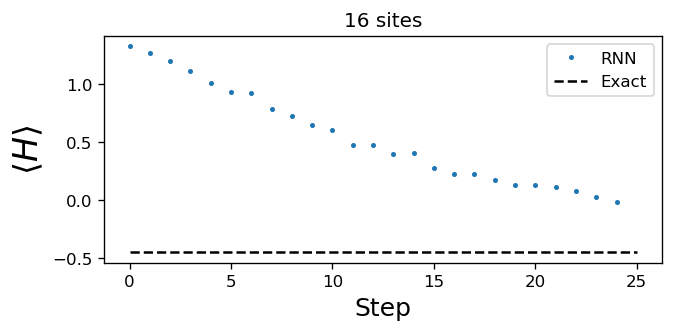

Final Error after 25 epochs is 0.43237168499396483
Final Energy -0.021041523665189743


In [10]:
vmc_final_energy = plot_E(energy, exact_energy[Lx], N, vmc_epochs, 0)

In [11]:
vmc, energy, variance = run_VMC(vmc, qmc_epochs, delta, qmc_dataset, energy, variance)

  0%|          | 0/25 [00:00<?, ?it/s]

Running VMC using QMC data for delta =  1.0


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


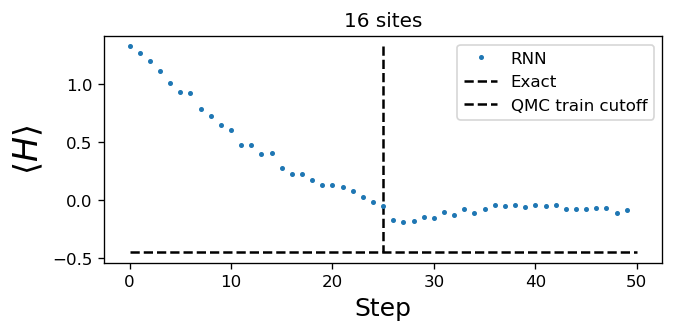

Final Error after 50 epochs is 0.3679107033567254
Final Energy -0.0855025053024292


In [12]:
qmc_final_energy = plot_E(energy, exact_energy[Lx], N, total_epochs, vmc_epochs)

Theoretically, the new results for final E and error will be different each run because of sampling?

### Run with QMC data and then continue with VMC sampling

In [13]:
vmc_qmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,vmc_epochs,Lx, seed)
energy = []
variance = []
vmc_qmc, energy, variance = run_VMC(vmc_qmc, qmc_epochs, delta, qmc_dataset, energy, variance)

  0%|          | 0/25 [00:00<?, ?it/s]

Running VMC using QMC data for delta =  1.0


100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


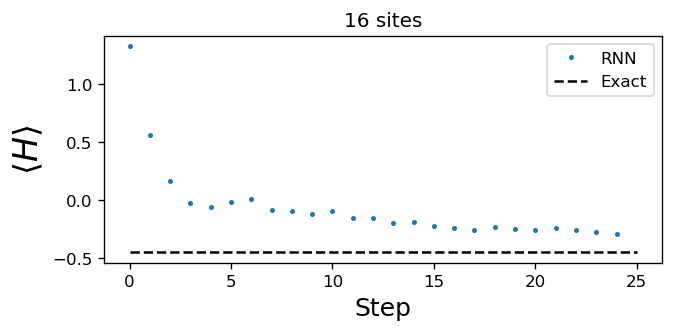

Final Error after 25 epochs is 0.16143267386720817
Final Energy -0.2919805347919464


In [14]:
qmc_final_energy = plot_E(energy, exact_energy[Lx], N, qmc_epochs, 0)

In [15]:
vmc_qmc, energy, variance = run_VMC(vmc_qmc, vmc_epochs, delta, None, energy, variance)

  0%|          | 0/25 [00:00<?, ?it/s]

Running VMC for delta = 1.0


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


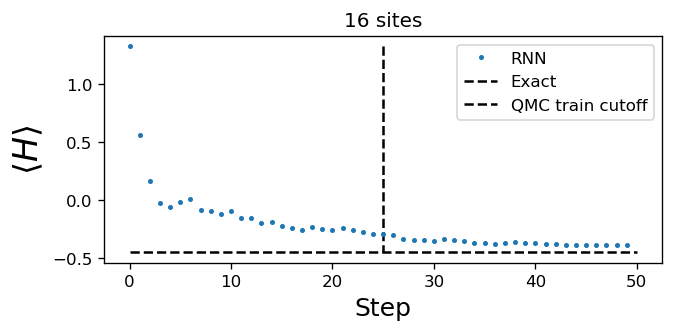

Final Error after 50 epochs is 0.059722354348165196
Final Energy -0.3936908543109894


In [16]:
qmc_vmc_final_energy = plot_E(energy, exact_energy[Lx], N, total_epochs, qmc_epochs)

### Run with VMC sampling for full time

In [17]:
vmc_qmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,total_epochs,Lx, seed)
energy = []
variance = []
vmc_qmc, energy, variance = run_VMC(vmc_qmc, total_epochs, delta, qmc_dataset, energy, variance)

  0%|          | 0/50 [00:00<?, ?it/s]

Running VMC using QMC data for delta =  1.0


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


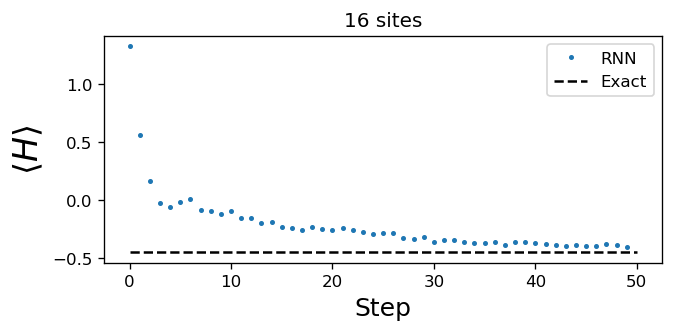

Final Error after 50 epochs is 0.0497949325399224
Final Energy -0.4036182761192322


In [18]:
qmc_final_energy = plot_E(energy, exact_energy[Lx], N, total_epochs, 0)

### Run with QMC data for full time

In [19]:
vmc_qmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,total_epochs,Lx, seed)
energy = []
variance = []
vmc_qmc, energy, variance = run_VMC(vmc_qmc, total_epochs, delta, None, energy, variance)

  0%|          | 0/50 [00:00<?, ?it/s]

Running VMC for delta = 1.0


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


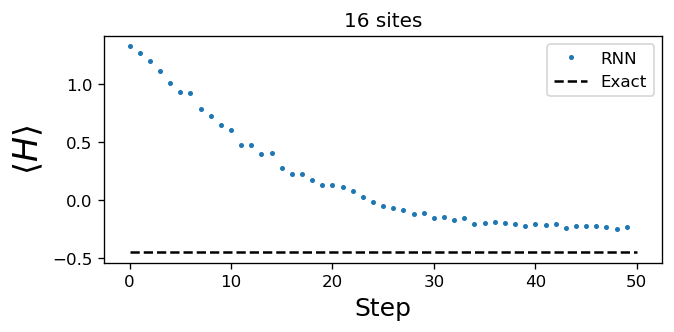

Final Error after 50 epochs is 0.21898404293821494
Final Energy -0.23442916572093964


In [20]:
vmc_final_energy = plot_E(energy, exact_energy[Lx], N, total_epochs, 0)

# Experiments summary


## Fixed parameters
batch_size = 100



**4 x 4**
- Exact Energy: -0.45776822
- Hidden units = 32

**VMC:** 
- samples = 1000, epochs = 1000
- Final Energy = -0.428250
- Final Error = 0.029519
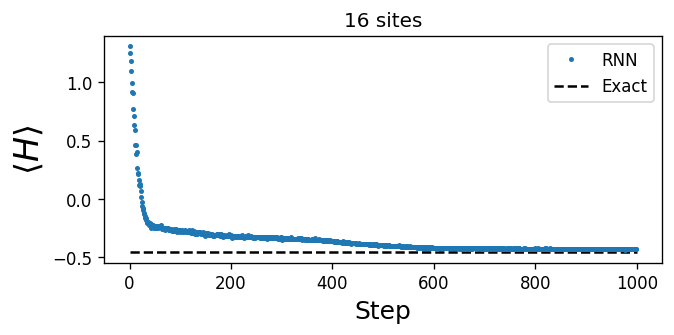


**QMC:**
- data = 1000, epochs = 500
- Final Energy = -0.43107
- Final Error = 0.026699

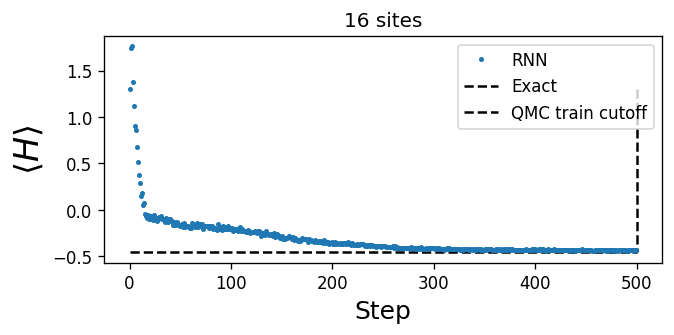

**QMC & VMC:**
- *Continuing using VMC from QMC*
  - samples = 1000, epochs = 500
  - Final Energy = -0.45572
  - Final Error = 0.002048


  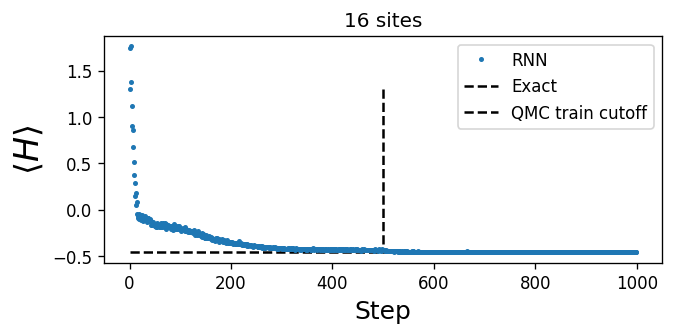

  

**8 x 8**
- DMRG Energy = -0.4870843
- QMC Energy =  -0.41079068589921375 +/- 0.00015929597162506545
- Hidden units = 50

**VMC:** 
- samples = 500, epochs = 500
- Final Energy = -0.3373688
- Final Error = 0.073421
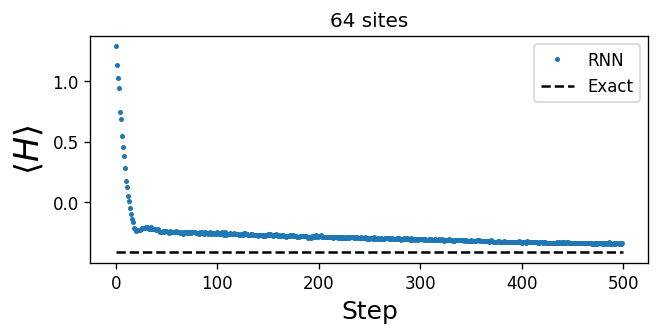

**QMC:**
- data = 1000, epochs = 100
- Final Energy = -0.21488
- Final Error = 0.1959

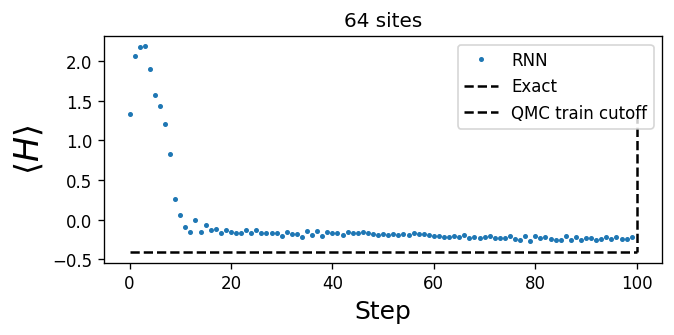

**QMC & VMC:** 
- *Continuing VMC from QMC*
  - samples = 500, epochs = 400
  - Final Energy = -0.38104
  - Final Error = 0.02975

  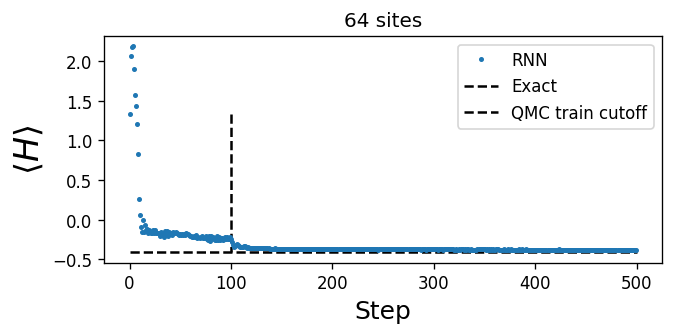

**12 x 12**
- QMC Energy =  -0.3952409191423294 +/- 0.00017185961929073537
- Hidden units = 16

**VMC:** 
- samples = 500, epochs = 250
- Final Energy = -0.271778
- Final Error = 0.123463

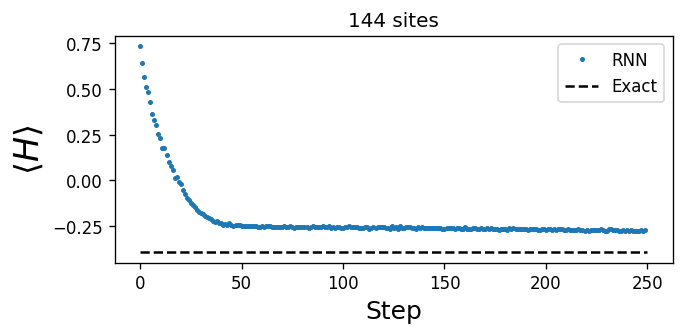

**QMC:**
- data = 1000, epochs = 50
- Final Energy = -0.15205
- Final Error = 0.243189

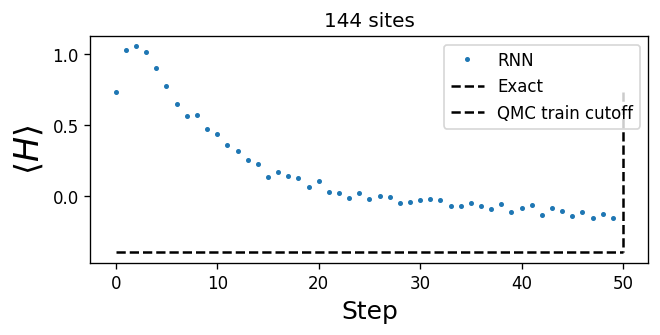

**QMC & VMC:**
- *Continuing VMC from QMC*
  - samples = 500, epochs = 200
  - Final Energy = -0.3228 
  - Final Error = 0.07244

  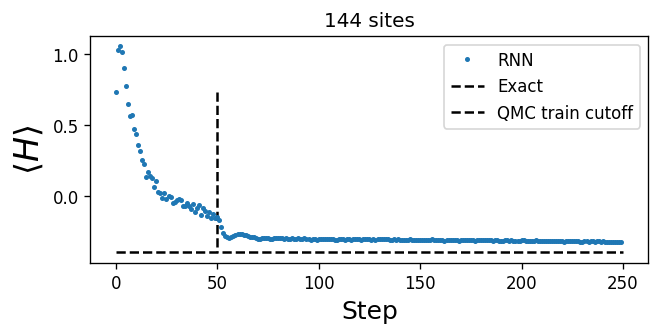

**16 x 16**
- QMC Energy =  -0.38780030058038656 +/- 0.0001786777979472486
- Hidden units = 4

**VMC:** 
- samples = 300, epochs = 100
- Final Energy = -0.04187
- Final Error = 0.34593
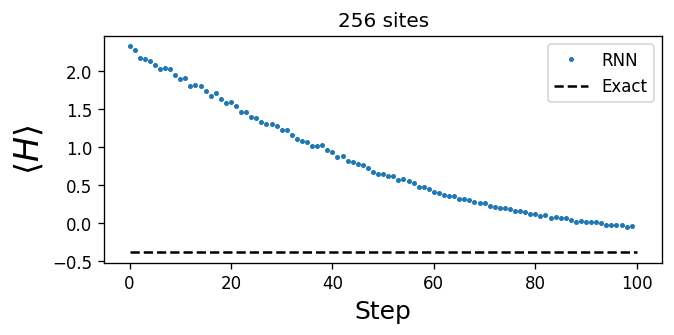

**QMC:**
- data = 1000, epochs = 25
- Final Energy = 2.2677
- Final Error = 1.8799
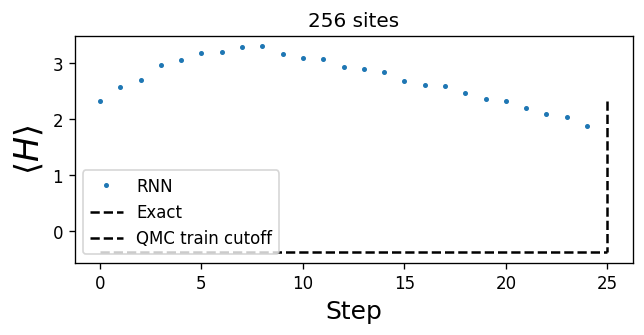
**QMC & VMC:**
- *Continuing VMC from QMC*
  - samples = 300, epochs = 75
  - Final Energy = -0.25963
  - Final Error = 0.12816


  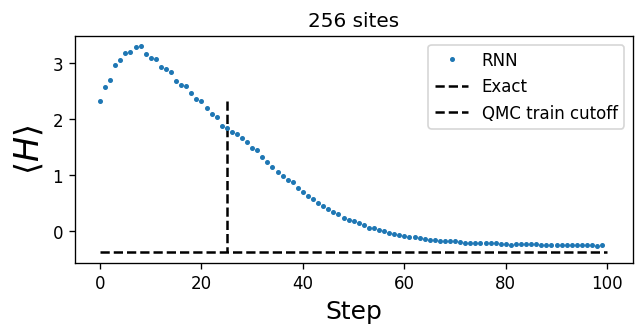

### No Truncation

Below we compare 4 possibilities for training a low expressive (32 hidden units for each GRU) for only  50 epochs total:
1. Training vmc, then qmc
2. Training qmc, then vmc
3. Training vmc
4. Training qmc

We find that it is the most effective to train qmc then vmc and training vmc then qmc being the worst. 

I need to investigate why qmc causes more error initially.

8x8

Hidden units: 32

50 total Epochs (~45 minutes)


VMC then QMC
- 1000 samples
- VMC for 25 epochs
  - Final error: 0.375132
  - Final energy: -0.03005
- QMC for 25 epochs
  - Final error: 0.77367
  - Final energy: 0.36849

  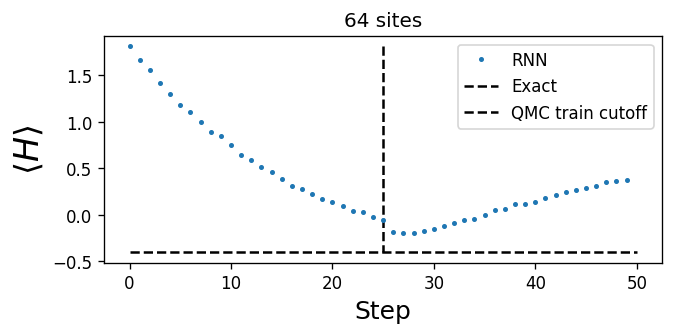

QMC then VMC
- 1000 samples
- QMC for 25 epochs
  - Final error: 0.24297
  - Final energy: -0.16221
- VMC for 25 epochs
  - Final error: 0.09096
  - Final energy: -0.16221

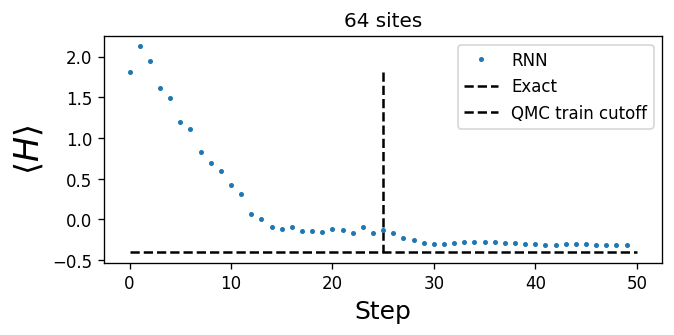

VMC Full
- 1000 samples
- 50 epochs
- Final error: 0.25469
- Final energy: -0.15048

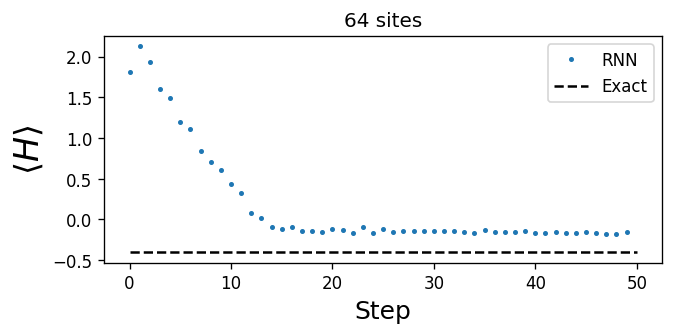

QMC Full
- 1000 samples
- 50 epochs
- Final error: 0.15585
- Final energy: -0.24932


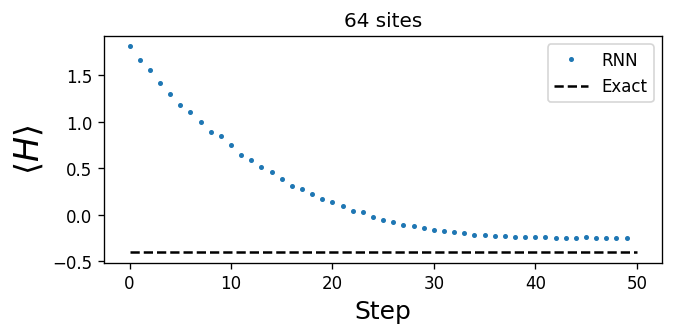